In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib import cm

In [2]:
class KDE:
    def __init__(self, kernel='gaussian'):
        self.kernel = kernel

    def _gaussian_kernel(self, u):
        return 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)

    def _box_kernel(self, u):
        return 0.5 if np.abs(u) <= 1 else 0

    def _triangular_kernel(self, u):
        return 1 - np.abs(u) if np.abs(u) <= 1 else 0

    def _kernel(self, u):
        if self.kernel == 'gaussian':
            return self._gaussian_kernel(u)
        elif self.kernel == 'box':
            return self._box_kernel(u)
        elif self.kernel == 'triangular':
            return self._triangular_kernel(u)
        else:
            raise ValueError('Unknown kernel.')

    def fit1D(self, data, h=None, num_points=100):
        x = np.linspace(np.min(data), np.max(data), num_points)
        if h is None:
            h = self._estimate_bandwidth_1D(data)
            print('estimated h : ',h)
        self.h = h
        # k = self._kernel(kernel_name)
        n = len(data)
        kde = np.zeros_like(x)
        for j in range(len(x)):
            for i in range(n):
                kde[j] += self._kernel((x[j] - data[i]) / h)
            kde[j] /= n * h
        return x, kde

    
    def fit(self, data, h=None, num_points=100):
        self.data = data

        if np.ndim(data)==1:
            return self.fit1D(data,h,num_points)
        
        if h is None:
            h = self._estimate_bandwidth(data)
        self.h = h

        min_val, max_val = np.min(data, axis=0), np.max(data, axis=0)
        linspace_values = [np.linspace(min_val[i], max_val[i], num_points) for i in range(data.shape[1])]
        meshgrid_values = np.meshgrid(*linspace_values)

        coordinates = np.vstack([dimension.flatten() for dimension in meshgrid_values]).T
        kde = np.zeros_like(coordinates[:, 0])

        # print('now fitting!')
        for i, coord in enumerate(coordinates):
            kde[i] = np.sum([self._kernel(np.linalg.norm((coord - data[j]) / h)) / (h**data.shape[1]) for j in range(data.shape[0])])

        kde_values = kde.reshape(meshgrid_values[0].shape)

        return meshgrid_values, kde_values

    # takes a lot of time (arounf 10 mins)
    
    
    def _estimate_bandwidth_1D(self, data):
        n = len(data)

        # Calculate the optimal bandwidth using MLCV
        # finding bandwidth in the range [-1,1] (can be changesd)
        
        bandwidths = 10 ** np.linspace(-1, 1, 100)
        log_likelihoods = []

        for bandwidth in bandwidths:
            log_likelihood = 0

            for i in range(n):
                # Leave-one-out cross-validation
                data_without_i = np.delete(data, i)
                kernel_sum = np.sum(np.exp(-0.5 * ((data[i] - data_without_i) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi)))
                log_likelihood += np.log(kernel_sum / (n - 1))

            log_likelihoods.append(log_likelihood)

        optimal_bandwidth = bandwidths[np.argmax(log_likelihoods)]
        return optimal_bandwidth

    
    def _estimate_bandwidth(self, data):

        n = len(data)
        bandwidths = 10 ** np.linspace(-1, 1, 100)
        log_likelihoods = []

        for bandwidth in bandwidths:
            log_likelihood = 0
            for i in range(n):
                data_without_i = np.delete(data, i, axis=0)
                kernel_sum = np.sum([self._kernel(np.linalg.norm((data[i] - data_without_i[j]) / bandwidth))
                    / (bandwidth**data.shape[1]) for j in range(data_without_i.shape[0])])

                log_likelihood += np.log(kernel_sum / (n - 1))

            log_likelihoods.append(log_likelihood)

        optimal_bandwidth = bandwidths[np.argmax(log_likelihoods)]
        return optimal_bandwidth
    
    def evaluate(self,x):
        if x.shape[0]==1:
            return self.evaluate1D(x)
        return np.sum([self._kernel(np.linalg.norm((x - self.data[j]) / self.h)) / (self.h**self.data.shape[1]) for j in range(self.data.shape[0])])
    
    def evaluate1D(self,x):
        ans = 0
        n = len(self.data)
        for i in range(n):
            ans += self._kernel((x - self.data[i]) / self.h)
        ans /= n * self.h
        return ans

        
    def plot_2d_density(self, meshgrid_values, kde_values, data):
        # print('plotting the dist.')
        plt.figure(figsize=(12, 8))
        plt.contourf(meshgrid_values[0], meshgrid_values[1], kde_values, cmap=cm.inferno, levels=20, alpha=0.85)
        plt.scatter(data[:, 0], data[:, 1], color='w', marker='.', label='Data Points')
        plt.xlabel('dimension 1')
        plt.ylabel('dimension 2')
        plt.title('Kernel Density Estimation in 2D')
        plt.legend()
        plt.show()
        
    def plot_1d_density(self, meshgrid_values, kde_values, data):
        plt.plot(meshgrid_values,kde_values, label='KDE')
        plt.fill_between(meshgrid_values, kde_values, color='skyblue', alpha=0.3)
        plt.scatter(data, np.zeros_like(data), color='black', label='Data Points', marker='.')
        plt.xlabel('x')
        plt.ylabel('p(x)')
        ttl = 'Kernel Density function for '+str(self.kernel)+' with h='+str(np.round(self.h,2))
        plt.title(ttl)
        plt.grid()
        plt.legend()
        plt.show()



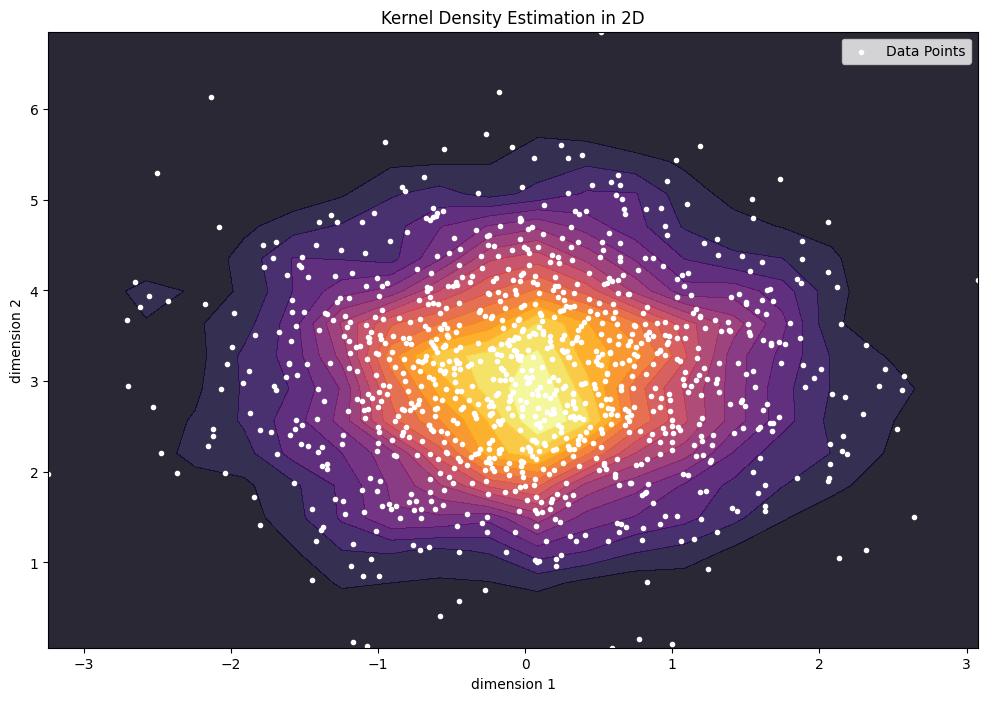

evaluation at point  [0 3]  :  164.30395242579357


In [3]:
# Generating 2D data
np.random.seed(42)
data_2d = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0], [0, 1]], size=1000)

# Creating and fitting KDE
kde = KDE(kernel='triangular')
meshgrid_values, kde_values = kde.fit(data=data_2d,num_points=20,h=0.5)

# Plotting the results
kde.plot_2d_density(meshgrid_values, kde_values, data_2d)


# evaluating at a point
p = np.array([0 ,3])
print('evaluation at point ',p,' : ',kde.evaluate(p))


[5.37640953 4.09794845 4.13033692 6.12543478 3.81058811 6.64267295
 4.09937927 5.63839193 4.67138152 5.60318743 4.455886   4.83720709
 5.04091918 3.99781254 5.74082435 4.48678643 4.77140008 4.00565063
 2.43766634 4.80897224 7.41261542 5.78460429 4.98073962 4.73710917
 5.02246589 5.54711912 3.81918718 6.11432169 5.71538132 5.71818573
 5.43847574 5.01961666 5.67286124 5.59181413 4.64595929 4.42639823
 5.1018563  6.54902015 3.76089292 3.53247473 5.16476084 5.0508877
 5.17334166 5.2439532  4.77679775 6.48986344 3.39909602 4.17150298
 4.89674524 3.35681119 4.8241456  6.66147017 5.02088649 5.23070091
 3.73983523 4.38363859 4.62480362 4.6822849  6.2816438  5.55769106
 3.88854204 5.24650478 5.49822175 6.14014904 6.58054069 3.98490581
 4.18914249 3.74242214 4.76598014 5.46635837 5.98733452 4.92404898
 4.68015248 5.15175799 4.1648571  7.08953872 3.39233897 5.18474058
 7.02360622 5.00679984 4.80996096 4.64255458 4.81960832 6.37284847
 2.78813809 6.5334337  3.57604285 4.73334767 4.57075558 5.58855

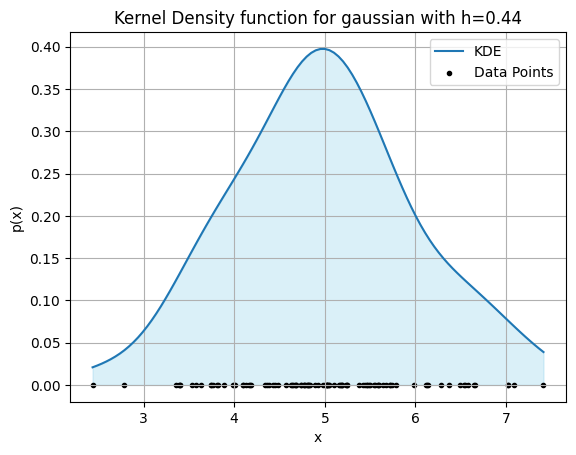

evaluation at point  [4.9]  :  [0.3957995]


In [5]:
# generating 1D data 
mean = 5
std_dev = 1
N = 100
X = np.random.normal(mean, std_dev, N)
print(X)

# creating and fitting KDE
kde = KDE(kernel='gaussian')
meshgrid_values, kde_values = kde.fit(data=X,num_points=100)

# plotting the results
kde.plot_1d_density(meshgrid_values,kde_values,X)

# evaluating at a point
p = np.array([4.9])
print('evaluation at point ',p,' : ',kde.evaluate(p))